# Load data

In [1]:
import pandas as pd

df_netflix = pd.read_csv('../data/netflix1.csv',
                         parse_dates=['date_added'],
                         dtype={'release_year':'Int64'})

# Duration convertieren in Seasons and minutes (movies are in min, TV-Shows=seasons)
df_netflix["duration_minutes"] = df_netflix["duration"].str.extract(r"(\d+)\s*min", expand=False).astype("Int64")
df_netflix["seasons"] = df_netflix["duration"].str.extract(r"(\d+)\s*Season", expand=False).astype("Int64")

# Translate Ratigns
rating_map = {
    "G": ("General Audience – alle Altersgruppen geeignet", 0),
    "PG": ("Elterliche Aufsicht empfohlen", 8),
    "PG-13": ("Ab 13 Jahren, elterliche Begleitung empfohlen", 13),
    "R": ("Ab 17, nur mit Eltern erlaubt", 17),
    "NC-17": ("Nur Erwachsene, keine Zuschauer unter 18", 18),
    "TV-Y": ("Geeignet für Kleinkinder (0–6)", 0),
    "TV-Y7": ("Ab 7 Jahren", 7),
    "TV-Y7-FV": ("Ab 7 Jahren (Fantasy Violence)", 7),
    "TV-G": ("Allgemein geeignet", 0),
    "TV-PG": ("Elterliche Aufsicht empfohlen (ab ca. 10)", 10),
    "TV-14": ("Ab 14 Jahren", 14),
    "TV-MA": ("Nur für Erwachsene (ab 17)", 17),
    "NR": ("Nicht bewertet", None),
    "UR": ("Unrated / Nicht bewertet", None),
}

# Spalten ergänzen
df_netflix["rating_description"] = df_netflix["rating"].map(lambda x: rating_map.get(x, ("Unbekannt", None))[0])
df_netflix["rating_age"] = df_netflix["rating"].map(lambda x: rating_map.get(x, ("Unbekannt", None))[1])


## Pre-Checks

It looks like the seasons are only used for TV-Shows and duration_minutes for Movies but lets verify that properly

In [2]:
df_netflix["duration_unit"] = df_netflix["duration"].apply(
    lambda x: "min" if "min" in x else "season" if "Season" in x else "unknown"
)
print(df_netflix.groupby(["type", "duration_unit"]).size())


type     duration_unit
Movie    min              6126
TV Show  season           2664
dtype: int64


## Add features

### Extract Genre (Explode and OneHot)
listed_in is a multi-label-list for genres.

In [8]:
# Liste trennen
df_netflix["genres_list"] = df_netflix["listed_in"].str.split(", ")
# Jede Genre-Kombination in eine eigene Zeile
df_exploded = df_netflix.explode("genres_list")

genre_counts = df_exploded["genres_list"].value_counts()
print(genre_counts.head(10))


genres_list
International Movies        2752
Dramas                      2426
Comedies                    1674
International TV Shows      1349
Documentaries                869
Action & Adventure           859
TV Dramas                    762
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: count, dtype: int64


# Viusualisierungskonzepte

## Alluvial / Sankey

In [7]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import itertools

df = df_netflix.copy()

df["listed_in"] = df["listed_in"].astype(str)
df["country"] = df["country"].astype(str)
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")

# --- Explode genres ---
df["genres_list"] = df["listed_in"].str.split(", ")
df_exploded = df.explode("genres_list")

# --- Top 10 Länder und Genres ---
top_countries = df_exploded["country"].value_counts().nlargest(10).index
top_genres = df_exploded["genres_list"].value_counts().nlargest(10).index

df_exploded = df_exploded[df_exploded["country"].isin(top_countries) & df_exploded["genres_list"].isin(top_genres)]

# --- Jahrzehnte ---
df_exploded["decade"] = (df_exploded["release_year"] // 10 * 10).astype("Int64")
df_exploded["decade_str"] = df_exploded["decade"].astype(str) + "s"

# --- Count pro country → genre → decade ---
df_sankey = df_exploded.groupby(["country","genres_list","decade_str"]).size().reset_index(name="count")

# --- Nodes & Mapping ---
countries = df_sankey["country"].unique().tolist()
genres = df_sankey["genres_list"].unique().tolist()
decades = df_sankey["decade_str"].unique().tolist()

nodes = countries + genres + decades
label_to_idx = {label: i for i, label in enumerate(nodes)}

# --- Links ---
source = []
target = []
value = []

for _, row in df_sankey.iterrows():
    c = row["country"]
    g = row["genres_list"]
    d = row["decade_str"]
    count = row["count"]

    source.append(label_to_idx[c])
    target.append(label_to_idx[g])
    value.append(count)

    source.append(label_to_idx[g])
    target.append(label_to_idx[d])
    value.append(count)

# --- Node-Farben: linear interpolieren ---
def get_colors(n, colorscale):
    """Erstellt n Farben aus einem Plotly colorscale"""
    return [px.colors.sample_colorscale(colorscale, i/(n-1))[0] for i in range(n)]

node_colors = get_colors(len(countries), "Blues") + \
              get_colors(len(genres), "Oranges") + \
              get_colors(len(decades), "Greens")

# --- Sankey Plot ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color="lightgray"
    )
)])

fig.update_layout(title_text="Netflix: Top 10 Länder → Top 10 Genres → Jahrzehnte (farblich differenziert)", font_size=10)
fig.show()


In [8]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import itertools

df = df_netflix.copy()

df["listed_in"] = df["listed_in"].astype(str)
df["country"] = df["country"].astype(str)
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")

# Explode genres
df["genres_list"] = df["listed_in"].str.split(", ")
df_exploded = df.explode("genres_list")

# Top 10 Länder und Genres
top_countries = df_exploded["country"].value_counts().nlargest(10).index
top_genres = df_exploded["genres_list"].value_counts().nlargest(10).index
df_exploded = df_exploded[df_exploded["country"].isin(top_countries) & df_exploded["genres_list"].isin(top_genres)]

# Jahrzehnte
df_exploded["decade"] = (df_exploded["release_year"] // 10 * 10).astype("Int64")
df_exploded["decade_str"] = df_exploded["decade"].astype(str) + "s"

# Count pro country → genre → decade
df_sankey = df_exploded.groupby(["country","genres_list","decade_str"]).size().reset_index(name="count")

# Nodes & Mapping
countries = df_sankey["country"].unique().tolist()
genres = df_sankey["genres_list"].unique().tolist()
decades = df_sankey["decade_str"].unique().tolist()

nodes = countries + genres + decades
label_to_idx = {label: i for i, label in enumerate(nodes)}

# Links
source = []
target = []
value = []
link_colors = []

# Node-Farben für Flusszuweisung
country_colors = px.colors.qualitative.Set1  # genügend kontrastreiche Farben
genre_colors = px.colors.qualitative.Set2

country_color_map = {c: country_colors[i % len(country_colors)] for i, c in enumerate(countries)}
genre_color_map = {g: genre_colors[i % len(genre_colors)] for i, g in enumerate(genres)}

for _, row in df_sankey.iterrows():
    c = row["country"]
    g = row["genres_list"]
    d = row["decade_str"]
    count = row["count"]

    # Länder → Genres
    source.append(label_to_idx[c])
    target.append(label_to_idx[g])
    value.append(count)
    link_colors.append(country_color_map[c])  # Link Farbe = Source Land

    # Genres → Jahrzehnte
    source.append(label_to_idx[g])
    target.append(label_to_idx[d])
    value.append(count)
    link_colors.append(genre_color_map[g])  # Link Farbe = Source Genre

# Node-Farben neutral
node_colors = ["lightblue"]*len(nodes)

# Sankey Plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(title_text="Netflix: Top 10 Länder → Top 10 Genres → Jahrzehnte (Link-Farben nach Source)", font_size=10)
fig.show()


In [48]:
import pandas as pd
import plotly.graph_objects as go

df = df_netflix.copy()

# --- Genres vorbereiten ---
df["genres_list"] = df["listed_in"].astype(str).str.split(", ")
df_exploded = df.explode("genres_list")

# --- Optional: Top 10 Genres und Top 10 Länder ---
top_genres = df_exploded["genres_list"].value_counts().nlargest(10).index
top_countries = df_exploded["country"].value_counts().nlargest(10).index

df_exploded = df_exploded[df_exploded["genres_list"].isin(top_genres) & df_exploded["country"].isin(top_countries)]

# --- Count pro Genre -> Country ---
df_sankey = df_exploded.groupby(["genres_list","country"]).size().reset_index(name="count")

# --- Nodes & Mapping ---
genres = df_sankey["genres_list"].unique().tolist()
countries = df_sankey["country"].unique().tolist()
nodes = genres + countries
label_to_idx = {label: i for i, label in enumerate(nodes)}

# --- Links ---
source = [label_to_idx[row["genres_list"]] for _, row in df_sankey.iterrows()]
target = [label_to_idx[row["country"]] for _, row in df_sankey.iterrows()]
value = df_sankey["count"].tolist()

# --- Farben ---
import plotly.colors as pc
import itertools

genre_palette = pc.qualitative.Plotly[:len(genres)]
country_palette = pc.qualitative.Dark24[:len(countries)]
node_colors = list(itertools.chain(genre_palette, country_palette))

# --- Sankey Plot ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color="lightgray"
    )
)])

fig.update_layout(title_text="Netflix: Top Genres → Top Countries", font_size=12)
fig.show()


Kruskal-Wallis (rating vs release_year): H=1153.79, p=0.0000


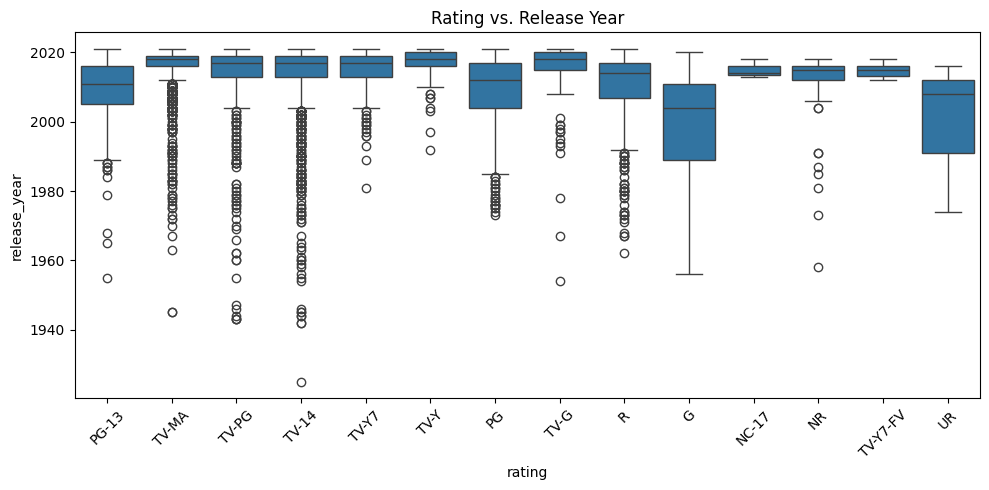

Kruskal-Wallis (rating vs duration): H=1428.93, p=0.0000


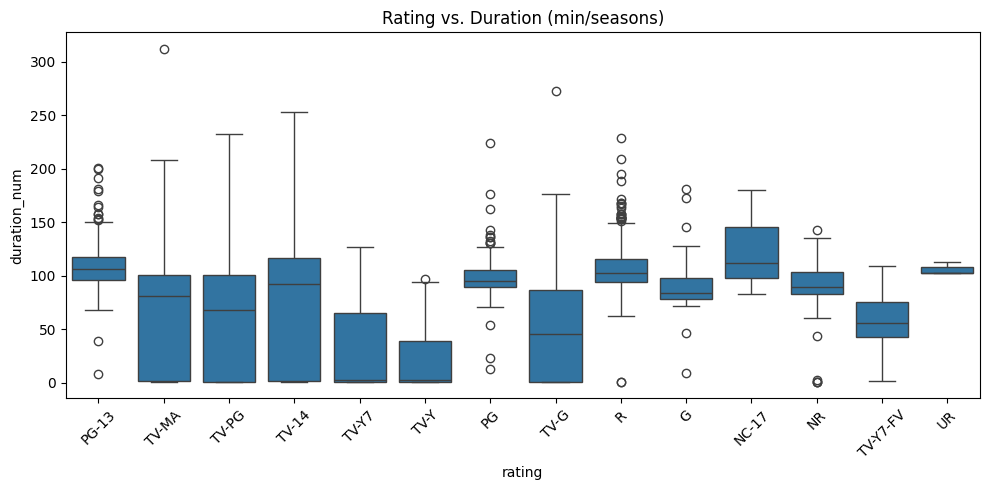

Chi²-Test (rating vs country): χ²=3641.62, p=0.0000


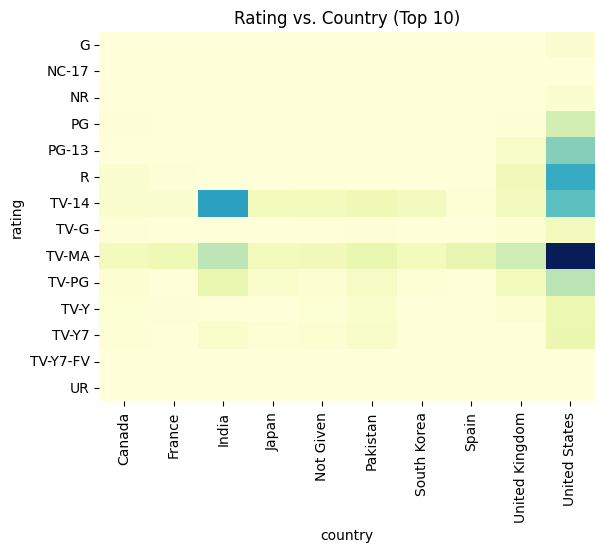

Korrelation (Rating ↔ Genre):
Kids' TV                     0.359725
TV Comedies                  0.125971
British TV Shows             0.082722
Movies                       0.081441
International TV Shows       0.078924
Docuseries                   0.076452
Stand-Up Comedy              0.068702
Crime TV Shows               0.064082
TV Action & Adventure        0.059013
Spanish-Language TV Shows    0.056278
Name: rating_code, dtype: float64


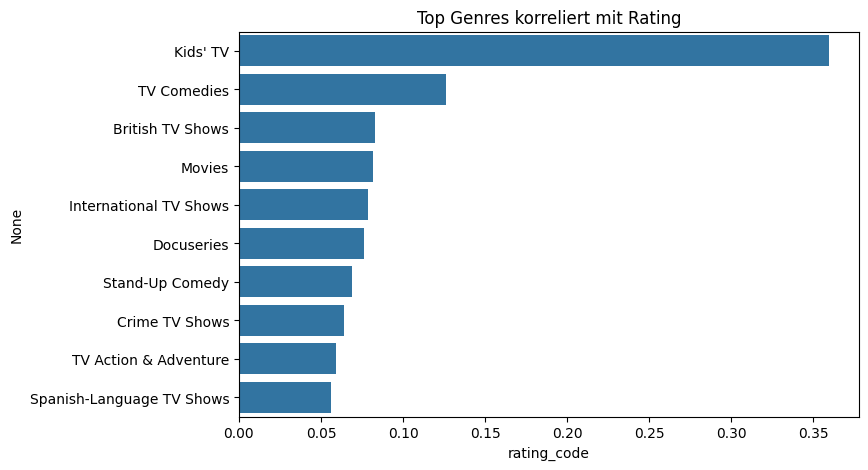

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, chi2_contingency

# Daten
df = df_netflix.copy()

# Cleaning
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")
df["duration_num"] = (
    df["duration"]
    .astype(str)
    .str.extract(r"(\d+)")  # nur Zahl
    .astype(float)
)
df["genres_list"] = df["listed_in"].astype(str).str.split(", ")
df = df.dropna(subset=["rating"])

# --- Rating vs Release Year ---
df_yr = df.dropna(subset=["release_year"])
stat, p_year = kruskal(
    *[group["release_year"].values for _, group in df_yr.groupby("rating")]
)
print(f"Kruskal-Wallis (rating vs release_year): H={stat:.2f}, p={p_year:.4f}")

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_yr, x="rating", y="release_year")
plt.title("Rating vs. Release Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Rating vs Duration ---
df_dur = df.dropna(subset=["duration_num"])
stat, p_dur = kruskal(
    *[group["duration_num"].values for _, group in df_dur.groupby("rating")]
)
print(f"Kruskal-Wallis (rating vs duration): H={stat:.2f}, p={p_dur:.4f}")

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_dur, x="rating", y="duration_num")
plt.title("Rating vs. Duration (min/seasons)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Rating vs Country ---
ct_country = pd.crosstab(df["rating"], df["country"])
chi2_country, p_country, _, _ = chi2_contingency(ct_country)
print(f"Chi²-Test (rating vs country): χ²={chi2_country:.2f}, p={p_country:.4f}")

# Heatmap der größten Länder
top_countries = df["country"].value_counts().nlargest(10).index
sns.heatmap(
    pd.crosstab(df[df["country"].isin(top_countries)]["rating"],
                df["country"]),
    cmap="YlGnBu",
    cbar=False
)
plt.title("Rating vs. Country (Top 10)")
plt.show()

# --- Rating vs Genre ---
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(
    mlb.fit_transform(df["genres_list"]),
    columns=mlb.classes_,
    index=df.index
)

genre_corr = pd.concat([df["rating"], genres_encoded], axis=1)
# Umwandeln Rating in numerische Codes
genre_corr["rating_code"] = genre_corr["rating"].astype("category").cat.codes
corrs = genre_corr.corr(numeric_only=True)["rating_code"].drop("rating_code").sort_values(ascending=False)

print("Korrelation (Rating ↔ Genre):")
print(corrs.head(10))

plt.figure(figsize=(8,5))
sns.barplot(x=corrs.head(10), y=corrs.head(10).index)
plt.title("Top Genres korreliert mit Rating")
plt.show()


/tmp/ipykernel_71696/3902742338.py:29: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



→ 539 Titel nach Sampling pro Jahr


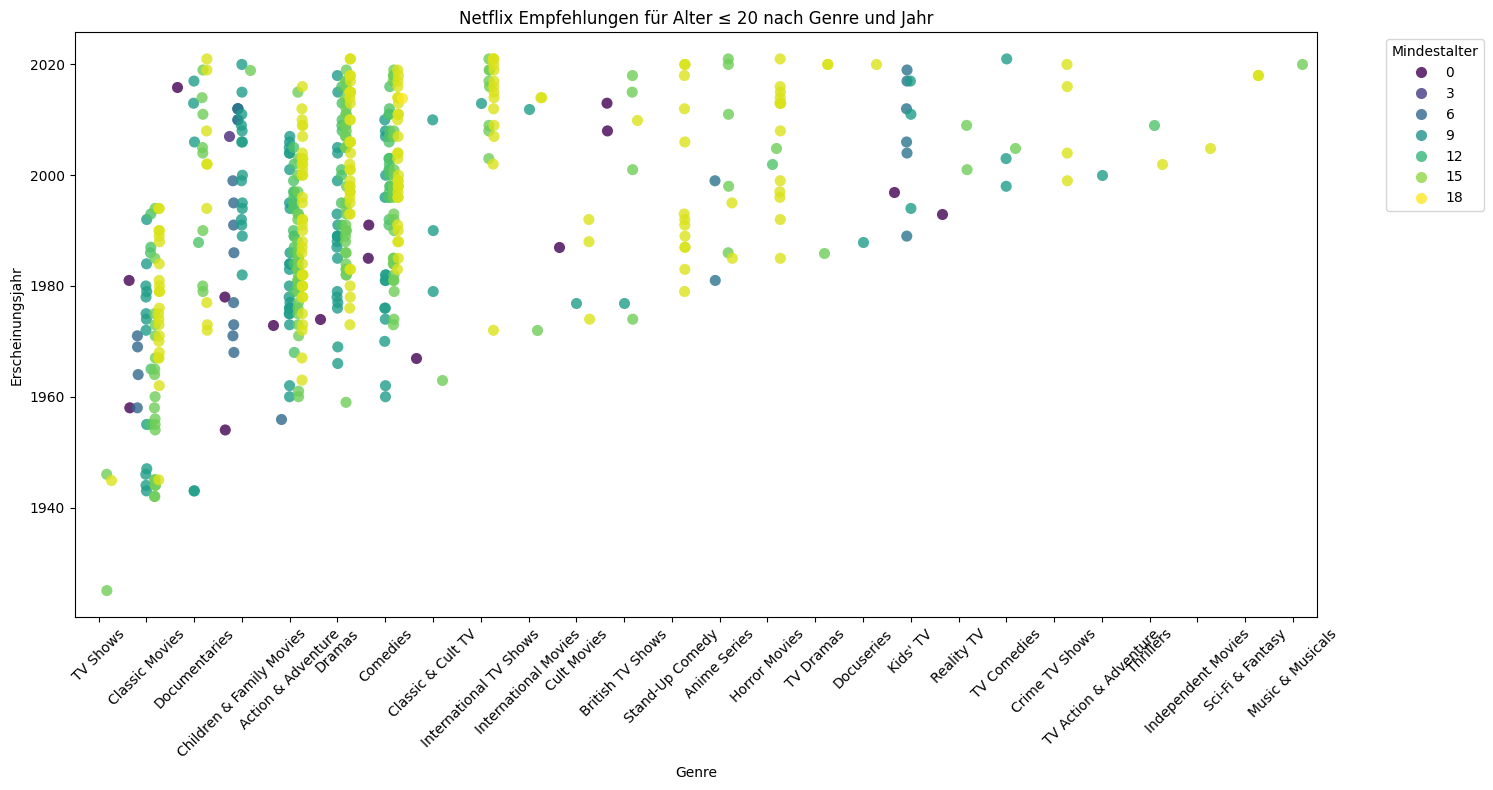

In [39]:
import pandas as pd
import numpy as np
import plotly.express as px

df = df_netflix.copy()

# Ratings säubern & Mindestalter zuweisen
df["rating"] = df["rating"].astype(str).str.strip().fillna("NR")
rating_age_map = {
    "TV-Y": 2, "TV-Y7": 7, "TV-Y7-FV": 7, "G": 6, "PG": 10, "PG-13": 13,
    "TV-PG": 10, "TV-14": 14, "TV-MA": 17, "R": 17, "NC-17": 18, "NR": 0, "UR": 0
}
df["min_age"] = df["rating"].map(lambda r: rating_age_map.get(r, 0))
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")

# Hauptgenre extrahieren
df["main_genre"] = df["listed_in"].astype(str).str.split(",").str[0].str.strip()

age = 20
top_n_per_year = 10

# Filter für Alter
subset = df[(df["min_age"].notna()) & (df["min_age"] <= age)].copy()

# Pro Jahr maximal top_n_per_year zufällig auswählen
def sample_per_year(group, n=10):
    return group.sample(min(len(group), n), random_state=42)

subset_sampled = subset.groupby("release_year").apply(sample_per_year, n=top_n_per_year).reset_index(drop=True)

print(f"→ {len(subset_sampled)} Titel nach Sampling pro Jahr")

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

sns.stripplot(
    data=subset_sampled,
    x="main_genre",
    y="release_year",
    hue="min_age",
    jitter=True,        # kleine horizontale Verschiebung, damit Punkte sichtbar bleiben
    dodge=True,         # Farbgruppen leicht verschieben
    palette="viridis",
    size=8,
    alpha=0.8
)

plt.xlabel("Genre")
plt.ylabel("Erscheinungsjahr")
plt.title(f"Netflix Empfehlungen für Alter ≤ {age} nach Genre und Jahr")
plt.xticks(rotation=45)
plt.legend(title="Mindestalter", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import plotly.express as px

df = df_netflix.copy()

# --- Genres vorbereiten ---
df["genres_list"] = df["listed_in"].astype(str).str.split(", ")
df_exploded = df.explode("genres_list")

# --- Optional: nur Top 20 Genres und Länder für bessere Übersicht ---
top_genres = df_exploded["genres_list"].value_counts().nlargest(10000).index
top_countries = df_exploded["country"].value_counts().nlargest(20).index

df_exploded = df_exploded[df_exploded["genres_list"].isin(top_genres) & df_exploded["country"].isin(top_countries)]

# --- Pivot für Heatmap ---
heatmap_data = df_exploded.groupby(["country","genres_list"]).size().reset_index(name="count")
heatmap_pivot = heatmap_data.pivot(index="country", columns="genres_list", values="count").fillna(0)

# --- Heatmap plotten ---
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Genre", y="Land", color="Anzahl Filme"),
    x=heatmap_pivot.columns,
    y=heatmap_pivot.index,
    color_continuous_scale="Viridis",
    text_auto=True
)

fig.update_layout(title="Netflix: Anzahl Filme pro Land vs Genre", xaxis_tickangle=-45)
fig.show()


In [11]:
df_exploded.genres_list.unique()

array(['Documentaries', 'Crime TV Shows', 'International TV Shows',
       'TV Action & Adventure', 'TV Dramas', 'TV Horror', 'TV Mysteries',
       'Children & Family Movies', 'Comedies', 'Dramas',
       'Independent Movies', 'International Movies', 'British TV Shows',
       'Reality TV', 'Music & Musicals', 'Movies', 'Docuseries',
       "Kids' TV", 'Romantic Movies', 'Horror Movies', 'Sci-Fi & Fantasy',
       'Thrillers', 'Spanish-Language TV Shows', 'TV Comedies',
       'TV Thrillers', 'Anime Series', 'Korean TV Shows',
       'Romantic TV Shows', 'Action & Adventure', 'Classic Movies',
       'Anime Features', 'Teen TV Shows', 'Stand-Up Comedy & Talk Shows',
       'Sports Movies', 'Science & Nature TV', 'Cult Movies',
       'Stand-Up Comedy', 'Faith & Spirituality', 'LGBTQ Movies',
       'TV Sci-Fi & Fantasy', 'TV Shows', 'Classic & Cult TV'],
      dtype=object)

In [5]:
df_netflix.country.unique()

array(['United States', 'France', 'Brazil', 'United Kingdom', 'India',
       'Germany', 'Pakistan', 'Not Given', 'China', 'South Africa',
       'Japan', 'Nigeria', 'Spain', 'Philippines', 'Australia',
       'Argentina', 'Canada', 'Hong Kong', 'Italy', 'New Zealand',
       'Egypt', 'Colombia', 'Mexico', 'Belgium', 'Switzerland', 'Taiwan',
       'Bulgaria', 'Poland', 'South Korea', 'Saudi Arabia', 'Thailand',
       'Indonesia', 'Kuwait', 'Malaysia', 'Vietnam', 'Lebanon', 'Romania',
       'Syria', 'United Arab Emirates', 'Sweden', 'Mauritius', 'Austria',
       'Turkey', 'Czech Republic', 'Cameroon', 'Netherlands', 'Ireland',
       'Russia', 'Kenya', 'Chile', 'Uruguay', 'Bangladesh', 'Portugal',
       'Hungary', 'Norway', 'Singapore', 'Iceland', 'Serbia', 'Namibia',
       'Peru', 'Mozambique', 'Ghana', 'Zimbabwe', 'Israel', 'Finland',
       'Denmark', 'Paraguay', 'Cambodia', 'Georgia', 'Soviet Union',
       'Greece', 'West Germany', 'Iran', 'Venezuela', 'Slovenia',
       'Gua